In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from micrograd.micrograd.engine import Value
from micrograd.micrograd.nn import Neuron, Layer, MLP
np.random.seed(1337)
random.seed(1337)

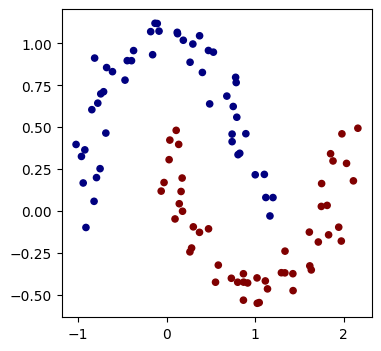

In [3]:
# make up a dataset
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.1)
y = y*2 -1  # make y be -1 or 1
# X.shape = (100,2), X = array([[a,b], [a,b], ...])
# y.shape = (100,), y = array([1,1,-1,-1,1...])
# X和y都是NumPy数组(numpy.ndarray), 是python机器学习常用数据格式。nd=N-dimensional, ndarray就是“N维数组”的意思。

# visualize in 2D
plt.figure(figsize=(4,4))  # 创建一个新的图形窗口，窗口大小5x5英寸。
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
# 取X第一列作为x坐标，X的第二列作为y坐标，c=y表示用y的值给点着色，s=20表示点的大小为20，cmap='jet'使用'jet'颜色映射

In [4]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-(hidden) layer neural network
print(model)
# MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
# ReLUNeuron(2) 表示当前Neuron有2个输入(2个w参数), 且经过了ReLU函数的激活。
# Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)] 表示当前Layer有3个Neuron, 输入维度为2, 输出维度为3。
print("number of parameters", len(model.parameters()))
# number of parameters 337
# parameters = model.parameters()  # list, len=337
# print(parameters)

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [5]:
# loss function
def loss(batch_size=None):
    # X.shape = (100,2), X = array([[a,b], [a,b], ...])
    # y.shape = (100,),  y = array([1,1,-1,-1,1...])

    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        # X.shape[0] = 100, 样本数目
        # np.random.permutation(100) = [5 59 3 41...] 生成0-99的随机排列数组。
        # np.random.permutation(X.shape[0])[:batch_size] 取随机排列数组的前batch_size个元素。
        Xb, yb = X[ri], y[ri]  # 取对应的样本特征和标签
        # Xb 是形状为(batch_size, 2)的NumPy数组，每行是一个样本的特征向量，例如 [[0.164, 0.117], [-1.022, 0.397], ...]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    # for xrow in Xb 遍历Xb的每一行(每个样本)
    # map(Value, row) 将xrow中的每个数值转换为Value对象, 例如 [0.164, 0.117] -> [Value(data=0.164, grad=0), Value(data=0.117, grad=0)]
    # map(function, iterable) 将函数应用到可迭代对象的每个元素上。
    # inputs = [[Value(), Value()], [Value(), Value()], ...]

    # forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))  # 计算当前batch所有sample的平均loss
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    # 符号一致即认为预测结果正确
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()  # 计算初始权重下在所有样本上的总损失和准确率。
print(total_loss, acc)

Value(data=0.8958441028683222, grad=0) 0.5


In [6]:
# optimization
for k in range(100):  # 100 training steps / gradient updates, 进行了100次参数更新，因为每一步都用全部数据进行前向传播，也可以理解为100个epoch。

    # forward
    total_loss, acc = loss()  # 前向传播获得损失值total_loss

    # backward
    model.zero_grad()  # 把所有参数的grad清零，防止和上一轮的梯度累加。
    total_loss.backward()  # 从total_loss出发，按计算图反向传播，给每个参与计算的Value填上对应的grad(即∂loss/∂参数)。

    # update (sgd)
    # SGD = Stochastic Gradient Descent (随机梯度下降) v.s. GD = Gradient Descent (标准梯度下降)
    # 标准梯度下降: 每步用全部训练样本算一次梯度，再更新参数。
    # SGD: 每步只用一个随机小批量(mini-batch)样本计算梯度，然后更新。
    learning_rate = 1.0 - 0.9*k/100  # 学习率衰减(learning rate decay)
    # 前期：大步快走。初始参数离最优解较远，用较大的学习率可以让loss快速下降，快速靠近好的区域，缩短训练时间。
    # 后期：小步精细。接近最优点时，梯度本身会变小，地形也更凭平，防止过大的学习率导致loss在最优点来回震荡，小学习率可以让参数稳定收敛，踩准最优点。
    for p in model.parameters():
        p.data -= learning_rate * p.grad  # 对每个参数p，沿梯度反方向更新参数，以减小loss。

    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


step 0 loss 0.8958441028683222, accuracy 50.0%
step 1 loss 1.7235905336972022, accuracy 81.0%
step 2 loss 0.742900631385113, accuracy 77.0%
step 3 loss 0.7705641260584202, accuracy 82.0%
step 4 loss 0.3692793385976538, accuracy 84.0%
step 5 loss 0.31354548191852205, accuracy 86.0%
step 6 loss 0.28142343497724337, accuracy 89.0%
step 7 loss 0.2688873331398391, accuracy 91.0%
step 8 loss 0.2567147286057416, accuracy 91.0%
step 9 loss 0.27048625516379227, accuracy 91.0%
step 10 loss 0.24507023853658036, accuracy 91.0%
step 11 loss 0.25099055297915035, accuracy 92.0%
step 12 loss 0.21560951851922944, accuracy 91.0%
step 13 loss 0.23090378446402732, accuracy 93.0%
step 14 loss 0.20152151227899434, accuracy 92.0%
step 15 loss 0.22574506279282228, accuracy 93.0%
step 16 loss 0.19447987596204092, accuracy 92.0%
step 17 loss 0.2108949619924637, accuracy 93.0%
step 18 loss 0.15983077356303585, accuracy 94.0%
step 19 loss 0.18453748746883927, accuracy 93.0%
step 20 loss 0.1897752285608762, accura

(-1.548639298268643, 1.951360701731357)

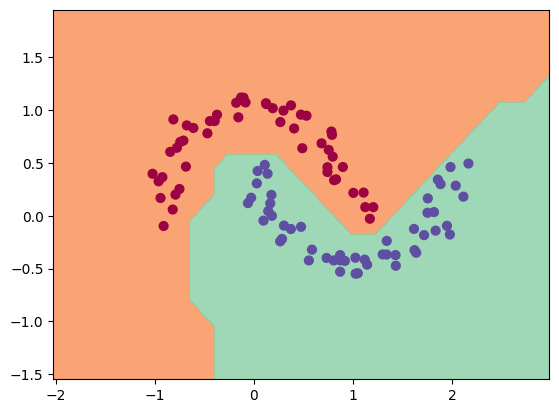

In [ ]:
# visualize decision boundary

h = 0.25
# X = array([[], [], ...]), X.shape = (100, 2)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
# X[:, 0] = array([1,2,...,100]), shape=(100,), 取X的所有行的第1列
# x_min = X第一列的最小值减1，x_max = X第一列的最大值加1。
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
# X[:, 1] = array([1,2,...,100]), shape=(100,), 取X的所有行的第2列
# y_min = X第二列的最小值减1，x_max = X第二列的最大值加1。
# x_min = np.float64(-2.0221939055140945), x_max = np.float64(3.1620559786436147)
# y_min = np.float64(-1.548639298268643),  y_max = np.float64(2.119389404636236)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
# np.arange()会生成一个等差的一维数组，用法和内置的range()很像，但返回的是NumPy的ndarray，而不是迭代器。
# np.arange(x_min, x_max, h) = array([1,2,...,21]),  shape=(21,)
# np.arange(y_min, y_max, h) = array([1,2,...,15]),  shape=(15,)
# xx = array([[], [], ...,[]]), shape=(15, 21)
# yy = array([[], [], ...,[]]), shape=(15, 21)
Xmesh = np.c_[xx.ravel(), yy.ravel()]
# xx.ravel() = array([1,2,...]), shape=(315,), 把xx按行展平成一维数组。
# yy.ravel() = array([1,2,...]), shape=(315,), 把yy按行展平成一维数组。
# np.c_[]按列拼接
# Xmesh = array([[-2.0, -1.54], [-1.77, -1.54], ..., []]), shape=(315, 2), 每一行[x,y]就是网格上的一个点。
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
# inputs:list = [[Value(), Value()],[],...,[]], len=315
scores = list(map(model, inputs))
# scores:list = [Value(), Value(), ...], len=315
Z = np.array([s.data > 0 for s in scores])
# Z = array([False, False, ...]), len=(315,)
Z = Z.reshape(xx.shape)  # xx.shape=(15, 21)
# Z.shape=(15, 21)

fig = plt.figure()  # 创建一个新的matplotlib图形窗口
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)  # 绘制填充等高线图，显示决策边界
# plt.contourf()用来画 填充等高线图（filled contour plot）
# xx,yy 是网格坐标
# Z 是每个网格点的预测结果(布尔值, 表示预测为正类或负类)
# cmap=plt.cm.Spectral 使用光谱颜色映射
# alpha=0.8 设置透明度
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)  # 绘制原始数据点
# X[:, 0], X[:, 1] 是数据点的 x、y 坐标
# c=y 用标签 y 给点着色（-1 或 1）
# s=40 设置点的大小
plt.xlim(xx.min(), xx.max())  # 设置坐标轴范围
plt.ylim(yy.min(), yy.max())
